In [ ]:
import logging as lg
import os

import contextily as cx
import geopandas as gpd
import numpy as np
import pandas as pd
import pooch
import seaborn as sns
from meteora.clients import GHCNHourlyClient, NetatmoClient
from shapely import geometry
from sklearn import decomposition, linear_model, model_selection, preprocessing

import multiurbanpy as mup
from multiurbanpy import settings

# disable pooch logs
logger = pooch.get_logger()
logger.setLevel("WARNING")

# enable multiurbanpy logs
lg.basicConfig(level=lg.INFO)
settings.LOG_CONSOLE = True


def aic(model, X_train, y_train, X_test, y_test, **fit_kwargs):
    """Compute Akaike Information Criterion (AIC) for the test set."""
    return 2 * X_train.shape[1] - 2 * np.log(
        np.sum(
            (y_test - model().fit(X_train, y_train, **fit_kwargs).predict(X_test)) ** 2,
            axis=0,
        )
    )

In [ ]:
# region = "https://zenodo.org/records/15102601/files/agglom-extent.gpkg?download=1"
# region = [6.5851, 46.5017, 6.67437, 46.5362]
region = [8.46617, 47.34707, 8.57655, 47.44401]
crs = "epsg:2056"

# Netatmo credentials
client_id = os.getenv("NETATMO_CLIENT_ID", default="")
client_secret = os.getenv("NETATMO_CLIENT_SECRET", default="")
scale = "1hour"  # default is "30min"

# to compute features
working_dir = "working-dir-zurich"
buffer_dists = [25, 50, 100, 250, 500]

In [ ]:
ghcnh_client = GHCNHourlyClient(region)
netatmo_client = NetatmoClient(region, client_id, client_secret)
stations_gdf = pd.concat(
    [
        gdf.assign(source=source)
        for source, gdf in zip(
            ["GHCNh", "Netatmo"],
            [ghcnh_client.stations_gdf, netatmo_client.stations_gdf],
        )
    ]
)

Gtk-Message: 21:37:20.032: Failed to load module "canberra-gtk-module"
Gtk-Message: 21:37:20.036: Failed to load module "canberra-gtk-module"


Enter authorization code:  b35c1e9dedaf07b61d1a206532bfc77a


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 58.82it/s]


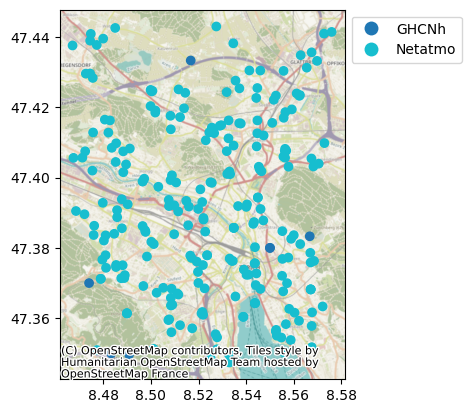

In [ ]:
ax = stations_gdf.plot("source", legend=True)
cx.add_basemap(ax, crs=stations_gdf.crs)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
site_gser = stations_gdf["geometry"].to_crs(crs)
reproj_region = gpd.GeoSeries([geometry.box(*region)], crs="epsg:4326").to_crs(crs)
fc = mup.FeatureComputer(
    region=reproj_region,
    working_dir=working_dir,
    crs=crs,
)

In [ ]:
bldg_features_df = fc.compute_bldg_features(site_gser, buffer_dists)
bldg_features_df

bldg_area  bldg_volume
station_id        buffer_dist                         
70:ee:50:00:22:66 25             4.991972    40.464684
                  50            10.982338    78.490899
                  100           40.934170   270.255233
                  250          192.690118  1331.556136
                  500          553.110494  4105.899695
...                                   ...          ...
SZU24-00036       100            3.993578    18.365324
                  250            8.985550    69.833291
                  500           30.950226   288.651657
SZU24-00037       250            1.996789    22.056202
                  500           10.982338    70.585952

[1191 rows x 2 columns]

In [ ]:
tree_features_ser = fc.compute_tree_features(site_gser, buffer_dists)
tree_features_ser

station_id         buffer_dist
70:ee:50:00:22:66  25             0.105934
                   50             0.119812
                   100            0.124523
                   250            0.115783
                   500            0.132623
                                    ...   
SZU24-00037        25             0.214414
                   50             0.213522
                   100            0.227050
                   250            0.219812
                   500            0.196269
Name: tree_canopy, Length: 1270, dtype: float64

In [ ]:
topo_features_df = fc.compute_topo_features_df(site_gser, buffer_dists)
topo_features_df

100%|███████████████████████████████████████████████| 254/254 [00:15<00:00, 15.91it/s]


slope  northness       tpi
station_id        buffer_dist                               
70:ee:50:00:22:66 25           0.265110  -0.309930 -0.027985
                  50           0.244481  -0.183817  0.095245
                  100          0.241793  -0.044411  0.396912
                  250          0.198055   0.165987 -2.383026
                  500          0.177147   0.337847 -8.104492
...                                 ...        ...       ...
SZU24-00037       25           0.249751   0.757637 -1.022095
                  50           0.262202   0.787692 -1.810303
                  100          0.267347   0.828181 -2.454346
                  250          0.261828   0.673885  1.089172
                  500          0.210091   0.475414  3.926819

[1270 rows x 3 columns]

In [ ]:
features_df = pd.concat(
    [bldg_features_df, tree_features_ser, topo_features_df], axis="columns"
).fillna(0)
# set elevation (even though is not multi-scale)
features_df["elevation"] = features_df.index.get_level_values("station_id").map(
    stations_gdf[["elevation", "altitude"]].bfill(axis="columns")["elevation"]
)

features_df

bldg_area  bldg_volume  tree_canopy     slope  \
station_id        buffer_dist                                                   
70:ee:50:00:22:66 25             4.991972    40.464684     0.105934  0.265110   
                  50            10.982338    78.490899     0.119812  0.244481   
                  100           40.934170   270.255233     0.124523  0.241793   
                  250          192.690118  1331.556136     0.115783  0.198055   
                  500          553.110494  4105.899695     0.132623  0.177147   
...                                   ...          ...          ...       ...   
SZM00006677       100            0.000000     0.000000     0.242106  0.677402   
                  250            0.000000     0.000000     0.208709  0.545901   
SZU24-00037       25             0.000000     0.000000     0.214414  0.249751   
                  50             0.000000     0.000000     0.213522  0.262202   
                  100            0.000000     0.000000     0.227050  0.267347   

                               northness       tpi  elevation  
station_id        buffer_dist                                  
70:ee:50:00:22:66 25           -0.309930 -0.027985      458.0  
                  50           -0.183817  0.095245      458.0  
                  100          -0.044411  0.396912      458.0  
                  250           0.165987 -2.383026      458.0  
                  500           0.337847 -8.104492      458.0  
...                                  ...       ...        ...  
SZM00006677       100          -0.596778 -1.123840      854.0  
                  250          -0.231386  6.871216      854.0  
SZU24-00037       25            0.757637 -1.022095      420.0  
                  50            0.787692 -1.810303      420.0  
                  100           0.828181 -2.454346      420.0  

[1270 rows x 7 columns]

### Maximizing site variation

In order to improve the statistical significance of the relationships between spatial patterns and the processes of interests, the selected sites and scale should cover the maximum possible range of landscape heterogeneity to maximize the variance of independent variables [1].

In [ ]:
flat_features_df = features_df.unstack("buffer_dist")
X = pd.DataFrame(
    preprocessing.StandardScaler().fit_transform(flat_features_df),
    columns=flat_features_df.columns,
)

target_evr = 0.9
for n_components in range(1, len(flat_features_df.columns)):
    pca = decomposition.PCA(n_components=n_components).fit(X)
    evr = pca.explained_variance_ratio_.sum()
    if evr >= target_evr:
        break
X_pca = pd.DataFrame(pca.transform(X), index=flat_features_df.index)

<Axes: ylabel='None-buffer_dist'>

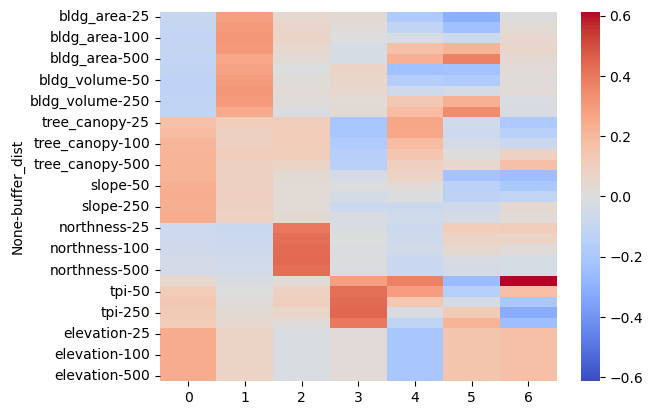

In [ ]:
load_df = pd.DataFrame(
    pca.components_.T, columns=X_pca.columns, index=flat_features_df.columns
)
v = load_df.abs().max().max()
sns.heatmap(load_df, cmap="coolwarm", vmin=-v, vmax=v)

<Axes: xlabel='0', ylabel='1'>

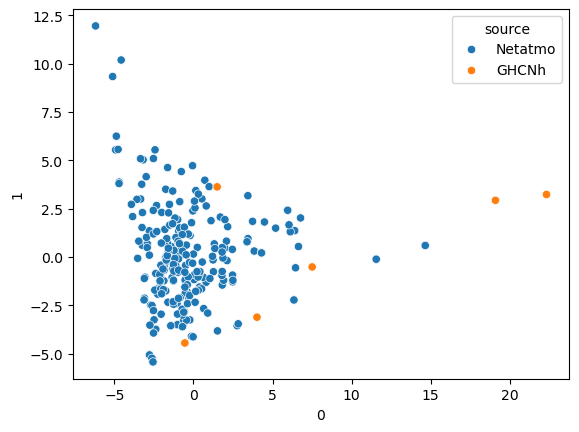

In [ ]:
sns.scatterplot(
    X_pca.assign(source=X_pca.index.map(stations_gdf["source"])),
    x=0,
    y=1,
    hue="source",
)

Text(0, 0.5, 'bldg_area-100')

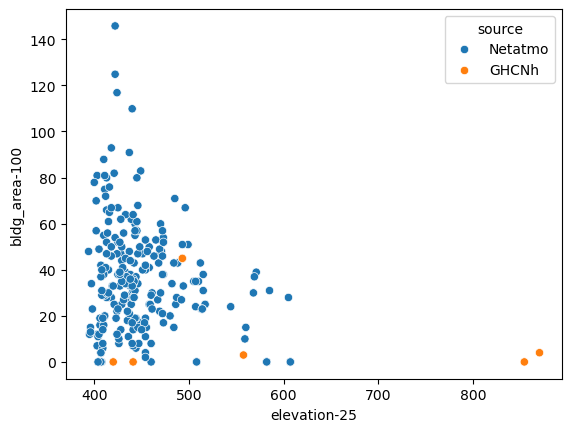

In [ ]:
x, y = (load_df.index[load_df[i].abs().argmax()] for i in range(2))
ax = sns.scatterplot(
    flat_features_df.assign(source=flat_features_df.index.map(stations_gdf["source"])),
    x=x,
    y=y,
    hue="source",
)
ax.set_xlabel(f"{x[0]}-{x[1]}")
ax.set_ylabel(f"{y[0]}-{y[1]}")


### Scale of effect

The *scale of effect* is the scale at which the relationship between the ecological process and the landscape spatial patterns show its strongest effect [2]. It is possible to statistically estimate the *scale of effect*, e.g., by exploring at which scale the selected model exhibits the strongest determination [3]:

Let us now get a time series of data during a heatwave in August 2023, defined as at least 3 consecutive days with an average temperature over 25$^{\circ}$C ([based on the heat level warning definitions by MeteoSwiss](https://www.meteoswiss.admin.ch/weather/weather-and-climate-from-a-to-z/heat-warnings.html)):

In [ ]:
variables = ["temperature"]
start = "18-08-2023"
end = "25-08-2023"
y = pd.concat(
    [
        ts_df.groupby("station_id").mean()
        for ts_df in [
            ghcnh_client.get_ts_df(variables, start, end),
            netatmo_client.get_ts_df(variables, start, end, scale=scale),
        ]
    ]
)

[########################################] | 100% Completed | 95.08 s


100%|███████████████████████████████████████████████| 247/247 [04:55<00:00,  1.19s/it]


<Axes: xlabel='Buffer dist.', ylabel='AIC'>

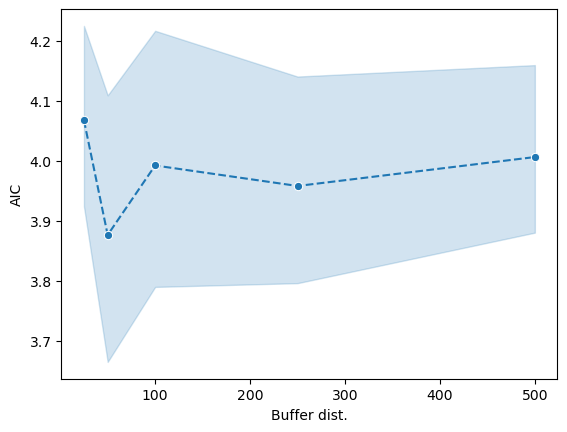

In [ ]:
n_repetitions = 10
test_size = 0.33

df = features_df.loc[y.index]
X_df = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df), index=df.index)

# model
model = linear_model.LinearRegression

results = []
for buffer_dist, df in X_df.groupby(level="buffer_dist"):
    # drop nan
    df = df.dropna()
    _y = y.loc[df.index.get_level_values("station_id")]
    for i in range(n_repetitions):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            df, _y, test_size=test_size, shuffle=True
        )
        results.append(
            (buffer_dist, i, aic(model, X_train, y_train, X_test, y_test).item())
        )
eval_df = pd.DataFrame(results, columns=["Buffer dist.", "repetition", "AIC"])
sns.lineplot(eval_df, x="Buffer dist.", y="AIC", marker="o", linestyle="--")